# 66% Consensus: BERT-Based Financial Sentiment Classifier

This document provides an explanation of the python script used to train a classifier on top of a BERT model via fine-tuning. The task is financial sentiment analysis, where sentences are classified into three sentiments: negative, neutral, and positive.

## Dataset

The dataset is [hosted on Hugging Face,](https://huggingface.co/datasets/financial_phrasebank) where you can find further information on its curation, motivation, and annotation.

### Overview

The dataset consists of 4846 lines, each containing a financial text sentence and its corresponding sentiment, separated by an '@' symbol. The sentiment can belong to one of three categories: Negative, Neutral, or Positive, and is distributed as:

- Neutral: 2879 entries (59%)
- Positive: 1363 entries (28%)
- Negative: 604 entries (12.4%)

### Data Fields

- **sentence**: A tokenized line from the dataset.
- **label**: A label representing the sentence class as a string: 'positive', 'negative', or 'neutral'.

### Data Splits

Although the dataset does not come with predefined training/validation/test splits, the sentences are categorized into different configurations based on the degree of agreement among the annotators:

- **sentences_50agree**: Number of instances with >= 50% annotator agreement - 4846 sentences
- **sentences_66agree**: Number of instances with >= 66% annotator agreement - 4217 sentences
- **sentences_75agree**: Number of instances with >= 75% annotator agreement - 3453 sentences
- **sentences_allagree**: Number of instances with 100% annotator agreement - 2264 sentences

For this project, we use the `sentences_50agree` configuration comprising of 4846 instances and manually split it into training, validation, and testing sets in a 70-15-15 proportion.

All sentences in the dataset are limited to fewer than 512 tokens, in accordance with the BERT model's input constraints.

## Imports and System Setup

The first part of the code includes importing necessary modules and setting up the TensorFlow environment to recognize accessible GPU devices.


## Metrics

The model's performance after training is evaluated based on accuracy and F1 score. Accuracy measures the proportion of correct predictions, while the F1 score provides a harmonic mean between precision and recall, hammered down for individual classes.

F1 score is calculated after each epoch by a custom F1_Evaluation class that uses the Scikit-learn function `f1_score()` for calculation.

We took the extra step of tracking the F1 score for the validation set for a few reasons due to using a financial dataset:

- **Handling Imbalance**: Financial datasets often exhibit class imbalance. For instance, genuine transactions significantly outnumber fraudulent ones. Accuracy can be misleading in such cases, making F1 a more balanced metric as it considers both precision and recall.

- **Balancing Costs**: Both false negatives (e.g., overlooking a negative sentiment) and false positives (e.g., misclassifying a neutral statement as negative) have implications. The F1 score ensures a balance between reducing these two error types.

- **Threshold Tuning**: Financial decisions can involve adjustable thresholds. The F1 score can guide optimization, ensuring neither precision nor recall is neglected.

## Wandb

[Wandb (Weights & Biases)](https://wandb.ai/site) is used for experiment tracking.

## Preprocessing

The data is read from the .txt file. The file encoding is first detected using the `chardet` library, and then the data is loaded into a pandas DataFrame using the detected encoding. The DataFrame contains two columns: sentence and label.

Then the data is split into train, validation, and test sets, stratifying on the label to respect the original distribution of classes in the dataset.

The `BertTokenizer` is used to encode the sentences into format suitable for the BERT model. `truncation=True` and `padding=True` ensures that all sequences are of the same length.

The tokenized sentence encodings and the corresponding labels are wrapped into TensorFlow's `Dataset` objects.

## Model Creation

The existing BERT model ('bert-base-uncased') from HuggingFace's transformer models is loaded for sequence classification with 3 labels (negative, neutral, positive).

## Model Compilation and Training

The model is compiled with Adam optimizer, `SparseCategoricalCrossentropy` loss function, and accuracy as a metric. We use `SparseCategoricalCrossentropy` as this is a  multi-class classification with integer labels (not one-hot encoded). It's memory-efficient, especially for many classes, and pairs with a softmax activation in the model's output.

A Wandb run is initialized, and the data is fit on the model using a batch size of 8 for 10 epochs. The validation data and the custom F1 score calculation callback are also passed in the fit method.

## Evaluation

The model is evaluated on the test set. Classification report and F1 score are printed to show detailed information about performance on all three categories. The F1 score is also logged to the Wandb run.

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=3dffd9c7bced2745a5111a7e8162a77e309db549d01393c385dfd1ad735ccd71
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import os

# Used to suppress output for F1 validation calculation
import io
import contextlib

# For encoding detection
import chardet

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Hugging Face Transformers for BERT
from transformers import BertTokenizer, TFBertForSequenceClassification

# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Ensure we have a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verify current GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Weights and Biases for tracking experiments
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import f1_score

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [6]:
# Custom callback for F1 evaluation at the end of each epoch
class F1_Evaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(F1_Evaluation, self).__init__()
        self.interval = interval
        self.dataset = validation_data
        self.X_val, self.y_val = [], []

        # Iterating over the dataset to get batches
        for batch in self.dataset:
            # Batch consists of inputs and labels
            inputs, labels = batch
            self.X_val.append(inputs)  # inputs is a dict with keys ['input_ids', 'attention_mask']
            self.y_val.append(np.atleast_1d(np.squeeze(labels.numpy())))  # Converting labels tensor to numpy array

        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        """Method called at the end of each epoch, calculating and logging F1 score."""
        print("\nCalculating validation F1 score...")
        # Process only for epochs with (epoch number modulo self.interval) equal to 0
        if epoch % self.interval == 0:
            y_pred = []

            # Iterate over inputs for each batch to generate predictions
            for X_val_batch in self.X_val:
                # Redirect stdout and stderr to avoid print statements inside keras.model.predict
                with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                    y_pred_single = self.model.predict(X_val_batch).logits
                # Softmax on logits and take class with maximum probability
                y_pred_single = tf.nn.softmax(y_pred_single).numpy().argmax(axis=-1)
                # Ensure that y_pred_single is at least a 1D array even if it is a scalar
                y_pred.append(np.atleast_1d(y_pred_single))

            # Concatenate all predictions and labels
            y_pred = np.concatenate(y_pred)
            y_val = np.concatenate(self.y_val)

            # Calculate F1 score and append to F1 scores list
            _f1 = f1_score(y_val, y_pred, average='weighted')
            self.f1_scores.append(_f1)

            print("Epoch: {} - validation_data f1_score: {:.4f}".format(epoch+1, _f1))

# Log in to W&B account for experiment tracking
wandb.login()

# Define the path to dataset
data_path = 'Sentences_66Agree.txt'

# Load raw data as binary
raw_data = open(data_path, 'rb').read()
# Detect encoding of the data (needed by pandas to import successfully with many text datasets)
result = chardet.detect(raw_data)
encoding = result['encoding']
print("Encoding is: " + encoding)

# Load data into a pandas dataframe with correct encoding and delimiter
df = pd.read_csv(data_path, delimiter='@', header=None, names=['sentence', 'label'], encoding=encoding)

# Split data into train, validation, and test sets with stratification
train,test = train_test_split(df,test_size=0.3,random_state=42,stratify=df['label'])
valid,test = train_test_split(test,test_size=0.5,random_state=42,stratify=test['label'])

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert texts to BERT input format
train_encodings = tokenizer(train.sentence.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(valid.sentence.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test.sentence.tolist(), truncation=True, padding=True)

def make_tf_dataset(encodings, labels):
    """Function to convert encodings and labels into tensorflow dataset."""
    input_ids = np.array(encodings['input_ids'])
    attention_mask = np.array(encodings['attention_mask'])
    labels = np.array(labels)
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, labels)).map(
        lambda input_ids, attention_mask, labels : ({"input_ids": input_ids, "attention_mask": attention_mask}, labels))

# Defining the labels keys and their respective values as per the model
label2num = {'negative':0,'neutral':1,'positive':2}
train_labels = [label2num[x] for x in train.label.tolist()]
val_labels = [label2num[x] for x in valid.label.tolist()]
test_labels = [label2num[x] for x in test.label.tolist()]

# Convert encodings and labels into tensorflow dataset
train_dataset = make_tf_dataset(train_encodings, train_labels)
val_dataset = make_tf_dataset(val_encodings, val_labels)
test_dataset = make_tf_dataset(test_encodings, test_labels)

# Load pre-trained BERT model with a classification layer on top
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define loss function, optimizer, and metrics
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# optimizer = keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Initializing wandb run
wandb.init(project="bert-sentiment", name="bert-finetune-run-66agree-10")

# Prepare for F1 score evaluation
val_dataset_temp = val_dataset.batch(8)
f1_evaluation = F1_Evaluation(validation_data=val_dataset_temp, interval=1)

# Add early stopping (disabled for now)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset.batch(8),
    validation_data=val_dataset_temp,
    epochs=10,
    callbacks=[WandbCallback(save_model=False), f1_evaluation] #, early_stopping]
)

# Evaluate the model with test dataset and show the classification report
y_test = test.label.map(label2num).values
y_pred = tf.nn.softmax(model.predict(test_dataset.batch(8)).logits).numpy().argmax(axis=-1)

print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# Log the F1 score to wandb
wandb.log({'f1_score': f1_score(y_test, y_pred, average='weighted')})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Encoding is: ISO-8859-1


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


accuracy,▁
epoch,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.81498
best_epoch,0
best_val_loss,0.29553
epoch,0
loss,0.47458
val_accuracy,0.88626


Epoch 1/10
369/369 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.8119
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.8894
369/369 [==============================] - 93s 133ms/step - loss: 0.4878 - accuracy: 0.8119 - val_loss: 0.2930 - val_accuracy: 0.8894
Epoch 2/10
369/369 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9292
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.8732
369/369 [==============================] - 30s 80ms/step - loss: 0.2044 - accuracy: 0.9292 - val_loss: 0.3873 - val_accuracy: 0.8705
Epoch 3/10
369/369 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9651
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.9080
369/369 [==============================] - 30s 82ms/step - loss: 0.1055 - accuracy: 0.9651 - val_loss: 0.3610 - val_accuracy: 0.9084
Epoch 4/10
369/369 [==============================] - ETA: 0s - loss: 0.073

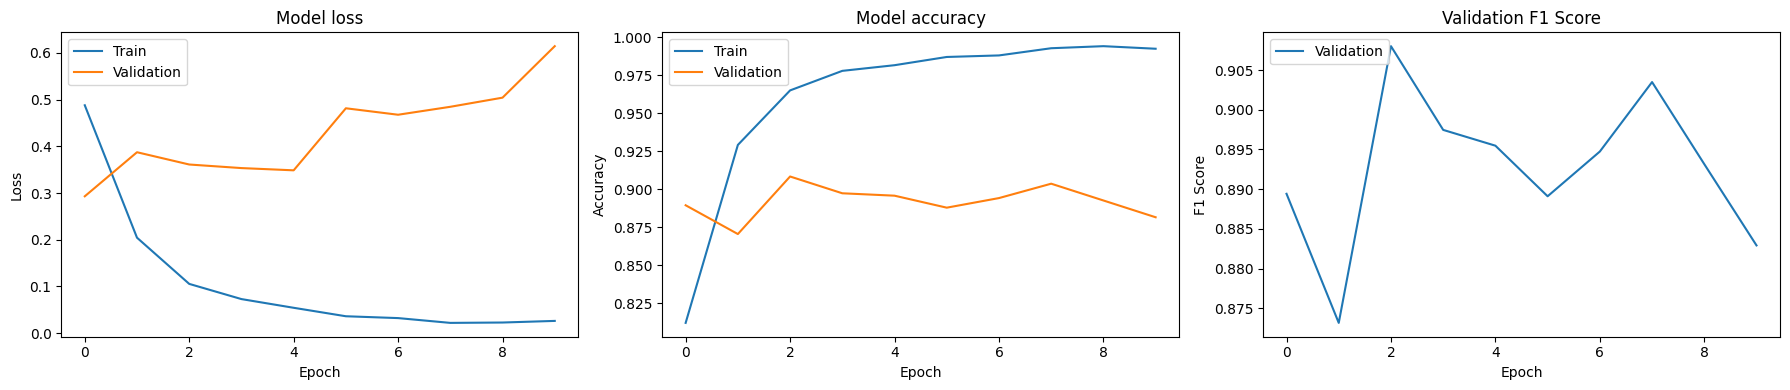

In [7]:
# Create a figure and a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# Plotting loss
axs[0].plot(history.history["loss"])
axs[0].plot(history.history["val_loss"])
axs[0].set_title("Model loss")
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train", "Validation"], loc="upper left")

# Plotting accuracy
axs[1].plot(history.history["accuracy"])
if "val_accuracy" in history.history:
    axs[1].plot(history.history["val_accuracy"])
axs[1].set_title("Model accuracy")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train", "Validation"], loc="upper left")

# Plotting Validation F1 Scores
axs[2].plot(f1_evaluation.f1_scores)
axs[2].set_title("Validation F1 Score")
axs[2].set_ylabel("F1 Score")
axs[2].set_xlabel("Epoch")
axs[2].legend(["Validation"], loc="upper left")

# Adjusts subplot params so they fit into the figure area
plt.tight_layout()
plt.show()